<a href="https://colab.research.google.com/github/Formula-Electric-Berkeley/FEBSim/blob/main/TyreOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the correct column names
column_names = ['ET', 'V', 'N', 'SA', 'IA', 'RL', 'RE', 'P', 'FX', 'FY', 'FZ', 'MX', 'MZ',
                'NFX', 'NFY', 'RST', 'TSTI', 'TSTC', 'TSTO', 'AMBTMP', 'SR']

# Function to load and prepare the data
def load_and_prepare_dataframe(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Failed to load {file_path}. Error: {e}")
        return None

    df = df.iloc[2:].reset_index(drop=True)

    # Drop empty or zero-length dataframes
    if len(df) > 0:
        return df
    else:
        print(f"File {file_path} has zero length after preprocessing.")
        return None

# Function to clean data
def clean_data(df):
    df['FY'] = pd.to_numeric(df['FY'], errors='coerce')  # Lateral force (negative for left turn)
    df['SA'] = pd.to_numeric(df['SA'], errors='coerce')       # Slip angle
    df['FZ'] = pd.to_numeric(df['FZ'], errors='coerce')       # Vertical load (negative downward)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['FY', 'SA', 'FZ'], inplace=True)
    return df

# Pacejka '94 Magic Formula for lateral force
def pacejka_lateral(SA, B, C, D, E):
    return D * np.sin(C * np.arctan(B * SA - E * (B * SA - np.arctan(B * SA))))

# Function to fit the Pacejka model to the tire data
def fit_pacejka(df):
    # Group data by vertical load bins
    df['FZ_bin'] = pd.cut(df['FZ'], bins=np.linspace(df['FZ'].min(), df['FZ'].max(), 5))
    bin_groups = df.groupby('FZ_bin')

    # Dictionary to store fitted parameters for each vertical load bin
    pacejka_params = {}

    for name, group in bin_groups:
        if len(group) < 5:
            continue  # Skip bins with insufficient data

        SA = np.radians(group['SA'].values)  # Convert slip angle to radians
        FY = group['FY'].values
        FZ_mean = group['FZ'].mean()

        # Initial guess for parameters
        initial_guess = [1.0, 1.2, np.max(np.abs(FY)), 0.97]

        try:
            params, _ = curve_fit(pacejka_lateral, SA, FY, p0=initial_guess, maxfev=10000)
            pacejka_params[FZ_mean] = params
        except RuntimeError:
            continue  # Skip if fitting fails

    return pacejka_params

# Function to calculate dynamic loads with aero effects and load transfer
def calc_dynamic_loads(static_weights, downforce, aero_balance, h_cg, track_width, lateral_acceleration, mass):
    """
    Adjust static weights with aerodynamic downforce and balance, and include load transfer due to cornering.
    All forces are negative (downwards).
    """
    # Aerodynamic downforce distribution (negative values)
    front_downforce = downforce * aero_balance
    rear_downforce = downforce * (1 - aero_balance)

    # Adjust static weights with aero downforce
    adjusted_static_weights = [
        static_weights[0] + front_downforce / 2,  # Front left
        static_weights[1] + front_downforce / 2,  # Front right
        static_weights[2] + rear_downforce / 2,   # Rear left
        static_weights[3] + rear_downforce / 2    # Rear right
    ]

    # Total load transfer due to lateral acceleration
    # Load transfer is positive (from inside to outside wheels)
    total_load_transfer = (mass * lateral_acceleration * h_cg) / track_width

    # Distribute load transfer between left and right wheels (assuming left turn)
    # Left wheels gain positive vertical load (become less negative), right wheels gain negative load (more negative)
    dynamic_weights = [
        adjusted_static_weights[0] + total_load_transfer / 2,  # Front left (less negative)
        adjusted_static_weights[1] - total_load_transfer / 2,  # Front right (more negative)
        adjusted_static_weights[2] + total_load_transfer / 2,  # Rear left (less negative)
        adjusted_static_weights[3] - total_load_transfer / 2   # Rear right (more negative)
    ]

    return dynamic_weights

# Function to interpolate Pacejka parameters for given vertical load
def interpolate_pacejka_params(pacejka_params, FZ):
    FZ_values = np.array(sorted(pacejka_params.keys()))
    params_array = np.array([pacejka_params[FZ_i] for FZ_i in FZ_values])

    # Interpolate each parameter
    B_interp = np.interp(FZ, FZ_values, params_array[:, 0])
    C_interp = np.interp(FZ, FZ_values, params_array[:, 1])
    D_interp = np.interp(FZ, FZ_values, params_array[:, 2])
    E_interp = np.interp(FZ, FZ_values, params_array[:, 3])

    return B_interp, C_interp, D_interp, E_interp

# Function to optimize lateral acceleration
def optimize_lateral_acceleration(static_weights, mass, track_width, h_cg, pacejka_params, downforce, aero_balance):
    """
    Iteratively calculate the maximum lateral acceleration considering load transfer.
    """
    # Initial guess for lateral acceleration (in m/s^2)
    lateral_acc = 5.0  # Approx. 0.5g
    tolerance = 0.01
    max_iterations = 000
    iteration = 0

    while iteration < max_iterations:
        iteration += 1

        # Calculate dynamic loads
        dynamic_weights = calc_dynamic_loads(static_weights, downforce, aero_balance, h_cg, track_width, lateral_acc, mass)

        # Compute maximum lateral force for each tire
        tire_names = ['Front Left', 'Front Right', 'Rear Left', 'Rear Right']
        total_lateral_force = 0
        tire_forces = {}

        for i, tire in enumerate(tire_names):
            FZ = dynamic_weights[i]
            # Ensure FZ is within the range of the fitted parameters
            FZ_min = min(pacejka_params.keys())
            FZ_max = max(pacejka_params.keys())
            FZ_clipped = np.clip(FZ, FZ_min, FZ_max)

            # Interpolate Pacejka parameters for the current FZ
            B, C, D, E = interpolate_pacejka_params(pacejka_params, FZ_clipped)

            # Find the slip angle that maximizes lateral force
            SA_values = np.radians(np.linspace(-15, 15, 1000))  # Slip angle range in radians
            FY_values = pacejka_lateral(SA_values, B, C, D, E)
            max_FY = np.max(FY_values)
            optimal_SA = SA_values[np.argmax(FY_values)]

            tire_forces[tire] = {
                'FZ': FZ,
                'Max FY': max_FY,
                'Optimal SA (deg)': np.degrees(optimal_SA)
            }

            total_lateral_force += max_FY

        # Calculate new lateral acceleration
        new_lateral_acc = total_lateral_force / mass

        # Check for convergence
        if abs(new_lateral_acc - lateral_acc) < tolerance:
            break

        lateral_acc = new_lateral_acc

    else:
        print("Warning: Maximum iterations reached without convergence.")

    # Include final lateral acceleration in the results
    tire_forces['Lateral Acceleration (g)'] = lateral_acc / 9.81

    return tire_forces

# Main script
if __name__ == "__main__":
    # Example usage on a single file
    file_path = 'B2356raw5.dat'
    df = load_and_prepare_dataframe(file_path)
    df = clean_data(df)

    # Fit Pacejka model to the tire data
    pacejka_params = fit_pacejka(df)

    # Check if we have enough data to proceed
    if not pacejka_params:
        print("Not enough data to fit the Pacejka model.")
    else:
        # Vehicle parameters
        mass = 250  # Total mass of the car in kg
        mass_per_wheel = mass / 4
        g = 9.81  # Acceleration due to gravity
        static_weights = [-mass_per_wheel * g] * 4  # Static weights in N (negative downward)

        # Aero parameters
        downforce = -350  # Total downforce in N (negative downward)
        aero_balance = 0.5  # 50% front-rear balance

        # Vehicle geometry
        track_width = 1.05  # in meters
        h_cg = 0.25  # Center of gravity height in meters

        # Optimize lateral acceleration
        optimal_results = optimize_lateral_acceleration(static_weights, mass, track_width, h_cg,
                                                        pacejka_params, downforce, aero_balance)

        # Output the results
        for tire, results in optimal_results.items():
            if tire != 'Lateral Acceleration (g)':
                print(f"{tire}:")
                print(f"  Optimal Vertical Load (FZ): {results['FZ']:.2f} N")
                print(f"  Max Lateral Force (FY): {results['Max FY']:.2f} N")
                print(f"  Optimal Slip Angle (deg): {results['Optimal SA (deg)']:.2f}")
        print(f"\nMaximum Lateral Acceleration: {optimal_results['Lateral Acceleration (g)']:.2f} g")


<ipython-input-3-5d65d7ee3d6e>:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')


Successfully loaded B2356raw5.dat


<ipython-input-3-5d65d7ee3d6e>:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_groups = df.groupby('FZ_bin')


Front Left:
  Optimal Vertical Load (FZ): 46.61 N
  Max Lateral Force (FY): 554.29 N
  Optimal Slip Angle (deg): -9.05
Front Right:
  Optimal Vertical Load (FZ): -1447.86 N
  Max Lateral Force (FY): 2584.09 N
  Optimal Slip Angle (deg): -11.64
Rear Left:
  Optimal Vertical Load (FZ): 46.61 N
  Max Lateral Force (FY): 554.29 N
  Optimal Slip Angle (deg): -9.05
Rear Right:
  Optimal Vertical Load (FZ): -1447.86 N
  Max Lateral Force (FY): 2584.09 N
  Optimal Slip Angle (deg): -11.64

Maximum Lateral Acceleration: 2.56 g


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the correct column names
column_names = ['ET', 'V', 'N', 'SA', 'IA', 'RL', 'RE', 'P', 'FX', 'FY', 'FZ', 'MX', 'MZ',
                'NFX', 'NFY', 'RST', 'TSTI', 'TSTC', 'TSTO', 'AMBTMP', 'SR']

# Function to load and prepare the data
def load_and_prepare_dataframe(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Failed to load {file_path}. Error: {e}")
        return None

    df = df.iloc[2:].reset_index(drop=True)

    # Drop empty or zero-length dataframes
    if len(df) > 0:
        return df
    else:
        print(f"File {file_path} has zero length after preprocessing.")
        return None

# Function to clean data
def clean_data(df):
    df['FY'] = pd.to_numeric(df['FY'], errors='coerce')  # Lateral force (negative for left turn)
    df['SA'] = pd.to_numeric(df['SA'], errors='coerce')       # Slip angle
    df['FZ'] = pd.to_numeric(df['FZ'], errors='coerce')       # Vertical load (negative downward)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['FY', 'SA', 'FZ'], inplace=True)
    return df

# Pacejka '94 Magic Formula for lateral force
def pacejka_lateral(SA, B, C, D, E):
    return D * np.sin(C * np.arctan(B * SA - E * (B * SA - np.arctan(B * SA))))

# Function to fit the Pacejka model to the tire data
def fit_pacejka(df):
    # Group data by vertical load bins
    df['FZ_bin'] = pd.cut(df['FZ'], bins=np.linspace(df['FZ'].min(), df['FZ'].max(), 5))
    bin_groups = df.groupby('FZ_bin')

    # Dictionary to store fitted parameters for each vertical load bin
    pacejka_params = {}

    for name, group in bin_groups:
        if len(group) < 5:
            continue  # Skip bins with insufficient data

        SA = np.radians(group['SA'].values)  # Convert slip angle to radians
        FY = group['FY'].values
        FZ_mean = group['FZ'].mean()

        # Initial guess for parameters
        initial_guess = [1.0, 1.2, np.max(np.abs(FY)), 0.97]

        try:
            params, _ = curve_fit(pacejka_lateral, SA, FY, p0=initial_guess, maxfev=10000)
            pacejka_params[FZ_mean] = params
        except RuntimeError:
            continue  # Skip if fitting fails

    return pacejka_params

# Function to calculate dynamic loads with aero effects and load transfer
def calc_dynamic_loads(static_weights, downforce, aero_balance, h_cg, track_width, lateral_acceleration, mass):
    """
    Adjust static weights with aerodynamic downforce and balance, and include load transfer due to cornering.
    All forces are negative (downwards).
    """
    # Aerodynamic downforce distribution (negative values)
    front_downforce = downforce * aero_balance
    rear_downforce = downforce * (1 - aero_balance)

    # Adjust static weights with aero downforce
    adjusted_static_weights = [
        static_weights[0] + front_downforce / 2,  # Front left
        static_weights[1] + front_downforce / 2,  # Front right
        static_weights[2] + rear_downforce / 2,   # Rear left
        static_weights[3] + rear_downforce / 2    # Rear right
    ]

    # Total load transfer due to lateral acceleration
    # Load transfer is positive (from inside to outside wheels)
    total_load_transfer = (mass * lateral_acceleration * h_cg) / track_width

    # Distribute load transfer between left and right wheels (assuming left turn)
    # Left wheels gain positive vertical load (become less negative), right wheels gain negative load (more negative)
    dynamic_weights = [
        adjusted_static_weights[0] + total_load_transfer / 2,  # Front left (less negative)
        adjusted_static_weights[1] - total_load_transfer / 2,  # Front right (more negative)
        adjusted_static_weights[2] + total_load_transfer / 2,  # Rear left (less negative)
        adjusted_static_weights[3] - total_load_transfer / 2   # Rear right (more negative)
    ]

    return dynamic_weights

# Function to interpolate Pacejka parameters for given vertical load
def interpolate_pacejka_params(pacejka_params, FZ):
    FZ_values = np.array(sorted(pacejka_params.keys()))
    params_array = np.array([pacejka_params[FZ_i] for FZ_i in FZ_values])

    # Interpolate each parameter
    B_interp = np.interp(FZ, FZ_values, params_array[:, 0])
    C_interp = np.interp(FZ, FZ_values, params_array[:, 1])
    D_interp = np.interp(FZ, FZ_values, params_array[:, 2])
    E_interp = np.interp(FZ, FZ_values, params_array[:, 3])

    return B_interp, C_interp, D_interp, E_interp

# Function to optimize lateral acceleration
def optimize_lateral_acceleration(static_weights, mass, track_width, h_cg, pacejka_params, downforce, aero_balance):
    """
    Iteratively calculate the maximum lateral acceleration considering load transfer.
    """
    # Initial guess for lateral acceleration (in m/s^2)
    lateral_acc = 5.0  # Approx. 0.5g
    tolerance = 0.01
    max_iterations = 100
    iteration = 0

    while iteration < max_iterations:
        iteration += 1

        # Calculate dynamic loads
        dynamic_weights = calc_dynamic_loads(static_weights, downforce, aero_balance, h_cg, track_width, lateral_acc, mass)

        # Compute maximum lateral force for each tire
        tire_names = ['Front Left', 'Front Right', 'Rear Left', 'Rear Right']
        total_lateral_force = 0
        tire_forces = {}

        for i, tire in enumerate(tire_names):
            FZ = dynamic_weights[i]
            # Ensure FZ is within the range of the fitted parameters
            FZ_min = min(pacejka_params.keys())
            FZ_max = max(pacejka_params.keys())
            FZ_clipped = np.clip(FZ, FZ_min, FZ_max)

            # Interpolate Pacejka parameters for the current FZ
            B, C, D, E = interpolate_pacejka_params(pacejka_params, FZ_clipped)

            # Find the slip angle that maximizes lateral force
            SA_values = np.radians(np.linspace(-15, 15, 1000))  # Slip angle range in radians
            FY_values = pacejka_lateral(SA_values, B, C, D, E)
            max_FY = np.max(FY_values)
            optimal_SA = SA_values[np.argmax(FY_values)]

            tire_forces[tire] = {
                'FZ': FZ,
                'Max FY': max_FY,
                'Optimal SA (deg)': np.degrees(optimal_SA)
            }

            total_lateral_force += max_FY

        # Calculate new lateral acceleration
        new_lateral_acc = total_lateral_force / mass

        # Check for convergence
        if abs(new_lateral_acc - lateral_acc) < tolerance:
            break

        lateral_acc = new_lateral_acc

    else:
        print("Warning: Maximum iterations reached without convergence.")

    # Include final lateral acceleration in the results
    tire_forces['Lateral Acceleration (g)'] = lateral_acc / 9.81

    return tire_forces

# Function to compute per-tire forces for a given downforce
def compute_tire_forces_for_downforce(downforce, pacejka_params, static_weights, mass, track_width, h_cg, aero_balance):
    """
    Computes per-tire forces and optimal slip angles for a given downforce.
    """
    optimal_results = optimize_lateral_acceleration(static_weights, mass, track_width, h_cg,
                                                    pacejka_params, downforce, aero_balance)
    # Extract per-tire results
    tire_results = []
    for tire in ['Front Left', 'Front Right', 'Rear Left', 'Rear Right']:
        result = {
            'Downforce': downforce,
            'Tire': tire,
            'Max Lateral Force (FY)': optimal_results[tire]['Max FY'],
            'Optimal Slip Angle (deg)': optimal_results[tire]['Optimal SA (deg)'],
            'Optimal Vertical Load (FZ)': optimal_results[tire]['FZ']
        }
        tire_results.append(result)
    # Also, lateral acceleration
    lateral_acc_g = optimal_results['Lateral Acceleration (g)']
    return tire_results, lateral_acc_g

# Main script
if __name__ == "__main__":
    # Load data and fit Pacejka model
    file_path = 'B2356raw5.dat'  # Replace with your data file path
    df = load_and_prepare_dataframe(file_path)
    if df is not None:
        df = clean_data(df)
        pacejka_params = fit_pacejka(df)

        if not pacejka_params:
            print("Not enough data to fit the Pacejka model.")
        else:
            # Vehicle parameters
            mass = 250  # Total mass of the car in kg
            mass_per_wheel = mass / 4
            g = 9.81  # Acceleration due to gravity
            static_weights = [-mass_per_wheel * g] * 4  # Static weights in N (negative downward)

            # Aero parameters
            aero_balance = 0.5  # 50% front-rear balance

            # Vehicle geometry
            track_width = 1.05  # in meters
            h_cg = 0.25  # Center of gravity height in meters

            # The first number in downforce_values is the smallest downforce
            # The second number is the highest downforce
            # The third number is how many points in between it calculates for (bigger number equals more granular sweep)

            # Sweep over downforce values
            downforce_values = np.linspace(-500, -4000, 30)  # Negative values for downward force

            results_list = []

            for downforce in downforce_values:
                tire_results, lateral_acc_g = compute_tire_forces_for_downforce(
                    downforce, pacejka_params, static_weights, mass, track_width, h_cg, aero_balance
                )
                # Add lateral acceleration to each tire result
                for result in tire_results:
                    result['Lateral Acceleration (g)'] = lateral_acc_g
                    results_list.append(result)

            # Create dataframe
            results_df = pd.DataFrame(results_list)

            # Output the dataframe
            print(results_df)

            # Save the results to an Excel file
            results_df.to_excel('tire_results.xlsx', index=False)
            print("Results have been saved to 'tire_results.xlsx'.")
    else:
        print("Dataframe could not be loaded and processed.")


<ipython-input-9-a0cbe610fc5a>:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')


Successfully loaded B2356raw5.dat


<ipython-input-9-a0cbe610fc5a>:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_groups = df.groupby('FZ_bin')


       Downforce         Tire  Max Lateral Force (FY)  \
0    -500.000000   Front Left              554.286868   
1    -500.000000  Front Right             2584.085162   
2    -500.000000    Rear Left              554.286868   
3    -500.000000   Rear Right             2584.085162   
4    -620.689655   Front Left              554.286868   
..           ...          ...                     ...   
115 -3879.310345   Rear Right             2584.085162   
116 -4000.000000   Front Left             1514.942558   
117 -4000.000000  Front Right             2584.085162   
118 -4000.000000    Rear Left             1514.942558   
119 -4000.000000   Rear Right             2584.085162   

     Optimal Slip Angle (deg)  Optimal Vertical Load (FZ)  \
0                   -9.054054                    9.106436   
1                  -11.636637                -1485.356436   
2                   -9.054054                    9.106436   
3                  -11.636637                -1485.356436   
4         

In [ ]:
results_df

,Downforce,Tire,Max Lateral Force (FY),Optimal Slip Angle (deg),Optimal Vertical Load (FZ),Lateral Acceleration (g)
0,-500.000000,Front Left,554.286868,-9.054054,9.106436,2.559325
1,-500.000000,Front Right,2584.085162,-11.636637,-1485.356436,2.559325
2,-500.000000,Rear Left,554.286868,-9.054054,9.106436,2.559325
3,-500.000000,Rear Right,2584.085162,-11.636637,-1485.356436,2.559325
4,-620.689655,Front Left,554.286868,-9.054054,-21.065978,2.559325
...,...,...,...,...,...,...
115,-3879.310345,Rear Right,2584.085162,-11.636637,-2548.651926,3.307594
116,-4000.000000,Front Left,1514.942558,-8.993994,-636.978346,3.343377
117,-4000.000000,Front Right,2584.085162,-11.636637,-2589.271654,3.343377
118,-4000.000000,Rear Left,1514.942558,-8.993994,-636.978346,3.343377


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the correct column names
column_names = ['ET', 'V', 'N', 'SA', 'IA', 'RL', 'RE', 'P', 'FX', 'FY', 'FZ', 'MX', 'MZ',
                'NFX', 'NFY', 'RST', 'TSTI', 'TSTC', 'TSTO', 'AMBTMP', 'SR']

# Function to load and prepare the data
def load_and_prepare_dataframe(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Failed to load {file_path}. Error: {e}")
        return None

    df = df.iloc[2:].reset_index(drop=True)

    # Drop empty or zero-length dataframes
    if len(df) > 0:
        return df
    else:
        print(f"File {file_path} has zero length after preprocessing.")
        return None

# Function to clean data
def clean_data(df):
    df['FY'] = pd.to_numeric(df['FY'], errors='coerce')  # Lateral force
    df['SA'] = pd.to_numeric(df['SA'], errors='coerce')  # Slip angle
    df['FZ'] = pd.to_numeric(df['FZ'], errors='coerce')  # Vertical load
    df['IA'] = pd.to_numeric(df['IA'], errors='coerce')  # Camber angle
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['FY', 'SA', 'FZ', 'IA'], inplace=True)
    return df

# Pacejka '94 Magic Formula for lateral force
def pacejka_lateral(SA, B, C, D, E):
    return D * np.sin(C * np.arctan(B * SA - E * (B * SA - np.arctan(B * SA))))

# Function to fit the Pacejka model to the tire data
def fit_pacejka(df):
    # Group data by vertical load bins
    df['FZ_bin'] = pd.cut(df['FZ'], bins=np.linspace(df['FZ'].min(), df['FZ'].max(), 5))
    bin_groups = df.groupby('FZ_bin')

    # Dictionary to store fitted parameters for each vertical load bin
    pacejka_params = {}

    for name, group in bin_groups:
        if len(group) < 5:
            continue  # Skip bins with insufficient data

        SA = np.radians(group['SA'].values)  # Convert slip angle to radians
        FY = group['FY'].values
        FZ_mean = group['FZ'].mean()

        # Initial guess for parameters
        initial_guess = [1.0, 1.2, np.max(np.abs(FY)), 0.97]

        try:
            params, _ = curve_fit(
                pacejka_lateral,
                SA, FY, p0=initial_guess, maxfev=10000
            )
            pacejka_params[FZ_mean] = params
        except RuntimeError:
            continue  # Skip if fitting fails

    return pacejka_params

# Function to interpolate Pacejka parameters for given vertical load
def interpolate_pacejka_params(pacejka_params, FZ):
    FZ_values = np.array(sorted(pacejka_params.keys()))
    params_array = np.array([pacejka_params[FZ_i] for FZ_i in FZ_values])

    # Interpolate each parameter
    interpolated_params = []
    for i in range(params_array.shape[1]):
        param_interp = np.interp(FZ, FZ_values, params_array[:, i])
        interpolated_params.append(param_interp)

    return interpolated_params  # Returns list of interpolated parameters

# Main script
if __name__ == "__main__":
    # Load data and fit Pacejka model
    file_path = 'B2356raw5.dat'  # Replace with your data file path
    df = load_and_prepare_dataframe(file_path)
    if df is not None:
        df = clean_data(df)
        pacejka_params = fit_pacejka(df)

        if not pacejka_params:
            print("Not enough data to fit the Pacejka model.")
        else:
            # Vehicle parameters
            mass = 250  # Total mass of the car in kg
            mass_per_axle = mass / 2  # Mass per axle
            g = 9.81  # Acceleration due to gravity
            static_axle_weight = mass_per_axle * g  # Static weight per axle in N

            # Fixed camber angles
            camber_outside = 0  # degrees
            camber_inside = -1  # degrees

            # Vehicle geometry
            h_cg = 0.25  # Center of gravity height in meters
            track_width = 1.05  # Track width in meters

            # Aerodynamic parameters
            downforce_values = np.linspace(600, 4000, 5)  # Positive values for downforce
            aero_balance = 0.5  # Fraction of downforce on the front axle

            results_list = []

            for downforce in downforce_values:
                # Distribute downforce to the axle
                axle_downforce = downforce * aero_balance  # Adjust for front or rear axle as needed

                # Total axle weight including downforce
                axle_weight = static_axle_weight + axle_downforce  # Total vertical force on axle (N)

                # Lateral acceleration range to evaluate
                lateral_acc_values = np.linspace(0.1, 2.0, 100) * g  # From 0.1g to 2.0g

                for lateral_acc in lateral_acc_values:
                    # Calculate load transfer using vehicle mass (not axle weight)
                    load_transfer = (mass_per_axle * lateral_acc * h_cg) / track_width  # Load transfer in N

                    # Vertical loads on outside and inside tires
                    FZ_outside = (axle_weight / 2) + load_transfer
                    FZ_inside = (axle_weight / 2) - load_transfer

                    # Ensure vertical loads are positive
                    if FZ_inside <= 0:
                        break  # Inside tire has lifted off

                    # Interpolate Pacejka parameters for each tire
                    params_outside = interpolate_pacejka_params(pacejka_params, FZ_outside)
                    params_inside = interpolate_pacejka_params(pacejka_params, FZ_inside)

                    # Compute maximum lateral force for each tire
                    SA_values = np.radians(np.linspace(-15, 15, 100))  # Slip angle range in radians

                    # Outside tire
                    B_o, C_o, D_o, E_o = params_outside
                    SA_o_opt = SA_values[np.argmax(pacejka_lateral(SA_values, B_o, C_o, D_o, E_o))]
                    FY_o_max = pacejka_lateral(SA_o_opt, B_o, C_o, D_o, E_o)

                    # Inside tire
                    B_i, C_i, D_i, E_i = params_inside
                    SA_i_opt = SA_values[np.argmax(pacejka_lateral(SA_values, B_i, C_i, D_i, E_i))]
                    FY_i_max = pacejka_lateral(SA_i_opt, B_i, C_i, D_i, E_i)

                    # Apply camber effect (simplified linear model)
                    camber_coefficient = 0.05  # Adjust as needed
                    camber_effect_outside = 1 + camber_coefficient * camber_outside
                    camber_effect_inside = 1 + camber_coefficient * camber_inside

                    FY_o_max *= camber_effect_outside
                    FY_i_max *= camber_effect_inside

                    # Total lateral force for the axle
                    total_FY = FY_o_max + FY_i_max

                    # Calculated lateral acceleration based on total lateral force
                    lateral_acc_calc = total_FY / (mass_per_axle * g)  # Divide by weight per axle

                    results_list.append({
                        'Downforce (N)': downforce,
                        'Lateral Acceleration (g)': lateral_acc / g,
                        'FZ Outside (N)': FZ_outside,
                        'FZ Inside (N)': FZ_inside,
                        'FY Outside (N)': FY_o_max,
                        'FY Inside (N)': FY_i_max,
                        'Total FY (N)': total_FY,
                        'Calculated Lateral Acc (g)': lateral_acc_calc,
                        'Optimal SA Outside (deg)': np.degrees(SA_o_opt),
                        'Optimal SA Inside (deg)': np.degrees(SA_i_opt)
                    })

            # Create dataframe
            results_df = pd.DataFrame(results_list)

            # Output the dataframe
            print(results_df)

            # Save the results to an Excel file
            results_df.to_excel('tire_results_fixed_camber_with_downforce.xlsx', index=False)
            print("Results have been saved to 'tire_results_fixed_camber_with_downforce.xlsx'.")
    else:
        print("Dataframe could not be loaded and processed.")


<ipython-input-10-fe1589ac53a2>:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')


Successfully loaded B2356raw5.dat


<ipython-input-10-fe1589ac53a2>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_groups = df.groupby('FZ_bin')


     Downforce (N)  Lateral Acceleration (g)  FZ Outside (N)  FZ Inside (N)  \
0            600.0                  0.100000      792.321429     733.928571   
1            600.0                  0.119192      797.924784     728.325216   
2            600.0                  0.138384      803.528139     722.721861   
3            600.0                  0.157576      809.131494     717.118506   
4            600.0                  0.176768      814.734848     711.515152   
..             ...                       ...             ...            ...   
495         4000.0                  1.923232     2174.640152    1051.609848   
496         4000.0                  1.942424     2180.243506    1046.006494   
497         4000.0                  1.961616     2185.846861    1040.403139   
498         4000.0                  1.980808     2191.450216    1034.799784   
499         4000.0                  2.000000     2197.053571    1029.196429   

     FY Outside (N)  FY Inside (N)  Total FY (N)  C

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the correct column names
column_names = ['ET', 'V', 'N', 'SA', 'IA', 'RL', 'RE', 'P', 'FX', 'FY', 'FZ', 'MX', 'MZ',
                'NFX', 'NFY', 'RST', 'TSTI', 'TSTC', 'TSTO', 'AMBTMP', 'SR']

# Function to load and prepare the data
def load_and_prepare_dataframe(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')
        print(f"Successfully loaded {file_path}")
    except Exception as e:
        print(f"Failed to load {file_path}. Error: {e}")
        return None

    df = df.iloc[2:].reset_index(drop=True)

    # Drop empty or zero-length dataframes
    if len(df) > 0:
        return df
    else:
        print(f"File {file_path} has zero length after preprocessing.")
        return None

# Function to clean data
def clean_data(df):
    df['FY'] = pd.to_numeric(df['FY'], errors='coerce')  # Lateral force
    df['SA'] = pd.to_numeric(df['SA'], errors='coerce')  # Slip angle
    df['FZ'] = pd.to_numeric(df['FZ'], errors='coerce')  # Vertical load
    df['IA'] = pd.to_numeric(df['IA'], errors='coerce')  # Camber angle
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['FY', 'SA', 'FZ', 'IA'], inplace=True)
    df['FZ'] = np.abs(df['FZ'])  # Ensure FZ is positive
    return df

# Extended Pacejka '94 Magic Formula for lateral force with FZ dependency
def pacejka_lateral_combined(SA, FZ, p):
    """
    Pacejka lateral force model with vertical load dependency.
    SA: Slip angle in radians
    FZ: Vertical load in N (positive)
    p: Parameters array [B0, B1, C0, D0, D1, E0, E1]
    """
    B0, B1, C0, D0, D1, E0, E1 = p
    D = (D0 + D1 * FZ) * FZ
    B = B0 + B1 * FZ
    C = C0
    E = E0 + E1 * FZ
    return D * np.sin(C * np.arctan(B * SA - E * (B * SA - np.arctan(B * SA))))

# Function to fit the combined Pacejka model to the tire data
def fit_pacejka_combined(df):
    SA = np.radians(df['SA'].values)  # Convert slip angle to radians
    FZ = df['FZ'].values
    FY = df['FY'].values

    # Initial guess for parameters
    initial_guess = [0.01, 0.0001, 1.4, 1.0, 0.0001, 0.97, 0.0001]

    # Fit the model
    try:
        params, _ = curve_fit(
            lambda xdata, *p: pacejka_lateral_combined(xdata[0], xdata[1], p),
            (SA, FZ), FY, p0=initial_guess, maxfev=100000
        )
        return params
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        return None

# Main script
if __name__ == "__main__":
    # Load data and fit Pacejka model
    file_path = 'B2356raw5.dat'  # Replace with your data file path
    df = load_and_prepare_dataframe(file_path)
    if df is not None:
        df = clean_data(df)
        pacejka_params = fit_pacejka_combined(df)

        if pacejka_params is None:
            print("Failed to fit the Pacejka model.")
        else:
            # Vehicle parameters
            mass = 310  # Total mass of the car in kg
            mass_per_axle = mass / 2  # Mass per axle
            g = 9.81  # Acceleration due to gravity
            static_axle_weight = mass_per_axle * g  # Static weight per axle in N

            # Fixed camber angles
            camber_outside = 0  # degrees
            camber_inside = -1  # degrees

            # Vehicle geometry
            h_cg = 0.25  # Center of gravity height in meters
            track_width = 1.05  # Track width in meters

            # Aerodynamic parameters
            downforce_values = np.arange(200, 2000, 50)  # More granular range from 400 to 2000 in increments of 50
            aero_balance = 0.5  # Fraction of downforce on the front axle

            results_list = []

            for downforce in downforce_values:
                # Distribute downforce to the axle
                axle_downforce = downforce * aero_balance  # Adjust for front or rear axle as needed

                # Total axle weight including downforce
                axle_weight = static_axle_weight + axle_downforce  # Total vertical force on axle (N)

                # Lateral acceleration range to evaluate
                lateral_acc_values = np.linspace(0.1, 2.0, 50) * g  # From 0.1g to 2.0g

                for lateral_acc in lateral_acc_values:
                    # Calculate load transfer using vehicle mass (not axle weight)
                    load_transfer = (mass_per_axle * lateral_acc * h_cg) / track_width  # Load transfer in N

                    # Vertical loads on outside and inside tires
                    FZ_outside = (axle_weight / 2) + load_transfer
                    FZ_inside = (axle_weight / 2) - load_transfer

                    # Ensure vertical loads are positive
                    if FZ_inside <= 0:
                        break  # Inside tire has lifted off

                    # Compute maximum lateral force for each tire
                    SA_values = np.radians(np.linspace(-15, 15, 100))  # Slip angle range in radians

                    # Outside tire
                    FY_o_values = pacejka_lateral_combined(SA_values, FZ_outside, pacejka_params)
                    max_index_o = np.argmax(FY_o_values)
                    SA_o_opt = SA_values[max_index_o]
                    FY_o_max = FY_o_values[max_index_o]

                    # Inside tire
                    FY_i_values = pacejka_lateral_combined(SA_values, FZ_inside, pacejka_params)
                    max_index_i = np.argmax(FY_i_values)
                    SA_i_opt = SA_values[max_index_i]
                    FY_i_max = FY_i_values[max_index_i]

                    # Apply camber effect (simplified linear model)
                    camber_coefficient = 0.01  # Adjust as needed
                    camber_effect_outside = 1 + camber_coefficient * camber_outside
                    camber_effect_inside = 1 + camber_coefficient * camber_inside

                    FY_o_max *= camber_effect_outside
                    FY_i_max *= camber_effect_inside

                    # Total lateral force for the axle
                    total_FY = FY_o_max + FY_i_max

                    # Calculated lateral acceleration based on total lateral force
                    lateral_acc_calc = total_FY / (mass_per_axle * g)  # Divide by weight per axle

                    results_list.append({
                        'Downforce (N)': downforce,
                        'Lateral Acceleration (g)': lateral_acc / g,
                        'FZ Outside (N)': FZ_outside,
                        'FZ Inside (N)': FZ_inside,
                        'FY Outside (N)': FY_o_max,
                        'FY Inside (N)': FY_i_max,
                        'Total FY (N)': total_FY,
                        'Calculated Lateral Acc (g)': lateral_acc_calc,
                        'Optimal SA Outside (deg)': np.degrees(SA_o_opt),
                        'Optimal SA Inside (deg)': np.degrees(SA_i_opt)
                    })

            # Create dataframe
            results_df = pd.DataFrame(results_list)

            # Output the dataframe
            print(results_df)

            # Save the results to an Excel file
            results_df.to_excel('tire_results_fixed_camber_with_downforce.xlsx', index=False)
            print("Results have been saved to 'tire_results_fixed_camber_with_downforce.xlsx'.")
    else:
        print("Dataframe could not be loaded and processed.")


<ipython-input-1-f4d0e85b6277>:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')


Successfully loaded B2356raw5.dat
      Downforce (N)  Lateral Acceleration (g)  FZ Outside (N)  FZ Inside (N)  \
0               200                  0.100000      846.478571     774.071429   
1               200                  0.138776      860.516691     760.033309   
2               200                  0.177551      874.554810     745.995190   
3               200                  0.216327      888.592930     731.957070   
4               200                  0.255102      902.631050     717.918950   
...             ...                       ...             ...            ...   
1795           1950                  1.844898     1915.693950     579.856050   
1796           1950                  1.883673     1929.732070     565.817930   
1797           1950                  1.922449     1943.770190     551.779810   
1798           1950                  1.961224     1957.808309     537.741691   
1799           1950                  2.000000     1971.846429     523.703571   

     

<ipython-input-58-0b8f803e4ed0>:20: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')


Successfully loaded B2356raw9.dat into df_2356


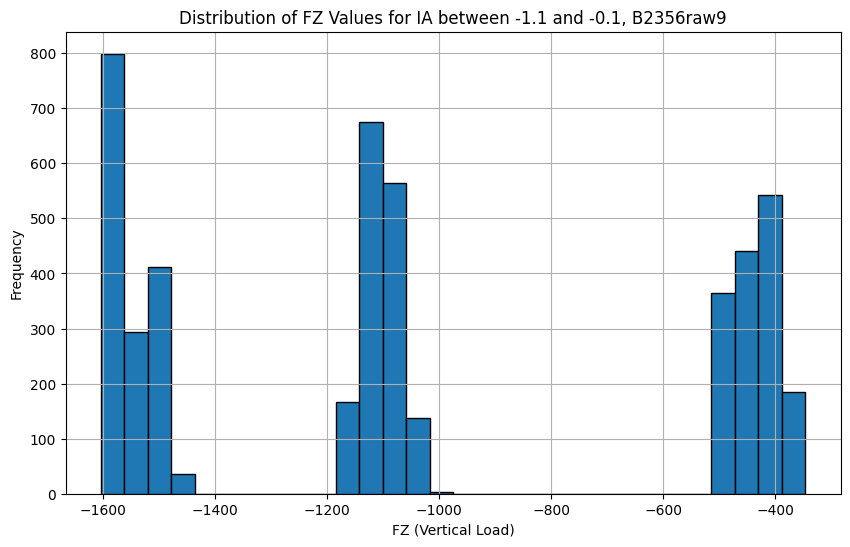

In [58]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Define the column names based on your data structure
column_names = ['ET', 'V', 'N', 'SA', 'IA', 'RL', 'RE', 'P', 'FX', 'FY', 'FZ', 'MX', 'MZ',
                'NFX', 'NFY', 'RST', 'TSTI', 'TSTC', 'TSTO', 'AMBTMP', 'SR']

def load_dataframe(file_path):
    # Extract the number from the filename to create the dataframe variable name
    match = re.search(r'(\d+)', file_path)
    if match:
        df_name = f"df_{match.group(1)}"
    else:
        df_name = "df"

    try:
        # Read the data using your specified logic
        df = pd.read_csv(file_path, delim_whitespace=True, names=column_names, on_bad_lines='skip')
        df = df.iloc[2:].reset_index(drop=True)  # Skip the first two rows
        df = df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric
        df.dropna(inplace=True)  # Drop rows with any NaN values
        print(f"Successfully loaded {file_path} into {df_name}")
    except Exception as e:
        print(f"Failed to load {file_path}. Error: {e}")
        return None, None

    return df_name, df

# Load the data into a variable named based on the file name
file_path = 'B2356raw9.dat'
df_name, df = load_dataframe(file_path)

if df is not None:
    # Make the dataframe available with the desired name
    globals()[df_name] = df

    # Filter data where IA (camber angle) is between -1.1 and -0.1
    df_filtered = df[(df['IA'] >= -1.1) & (df['IA'] <= -0.1)]

    # Check if the filtered DataFrame is not empty
    if not df_filtered.empty:
        # Create a plot of the distribution of FZ values in the filtered data
        plt.figure(figsize=(10, 6))
        plt.hist(df_filtered['FZ'], bins=30, edgecolor='black')
        plt.title('Distribution of FZ Values for IA between -1.1 and -0.1, B2356raw9')
        plt.xlabel('FZ (Vertical Load)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        print("No data found for the specified camber angle range.")
else:
    print("Dataframe could not be loaded.")


In [49]:
df['IA'].sort_values()

,IA
16639,-0.069
16643,-0.067
16640,-0.067
16642,-0.066
16638,-0.064
...,...
5838,4.025
6659,4.025
5081,4.026
5504,4.028


In [40]:
df_filtered = df[(df['FZ'] >= -1600) & (df['FZ'] <= -900)]
df_filtered['FZ']

,FZ
1318,-904.03
1319,-908.74
1320,-905.18
1328,-915.59
1329,-925.10
...,...
99646,-1029.29
99647,-1011.55
99648,-990.64
99649,-967.22


In [ ]:
[]